# 第17章 正則化で過学習に対応する
## 17.1 正則化とは
この節では、基本の線形回帰モデルのスコアを計算する

### データを読み込む

In [12]:
import polars as pl

acs= pl.read_csv("../data/acs_ny.csv")
acs.head()

# 計画行列に変換する
from patsy import dmatrices
y, X = dmatrices(
    "FamilyIncome ~ NumBedrooms + NumChildren + NumPeople + "
    "NumRooms + NumUnits + NumVehicles + NumWorkers + OwnRent + "
    "YearBuilt + ElectricBill + FoodStamp + HeatingFuel + "
    "Insurance + Language",
    data = acs,
)

# 学習用と検証用に計画行列を分割する
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, random_state = 0
)

### モデルのスコアを計算する

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 学習器の初期化
model = make_pipeline(
    StandardScaler(with_mean = False),
    LinearRegression()
)
display(model)

# 学習
model = model.fit(X_train, y_train)

model_coefs = pl.DataFrame({
    "variable": X.design_info.column_names,
    "coef_lr": model.named_steps["linearregression"].coef_[0].round(4),
})
display(model_coefs)

# モデルのスコア
display(model.score(X_eval, y_eval).round(5))

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('linearregression', LinearRegression())])

variable,coef_lr
str,f64
"""Intercept""",0.0
"""NumUnits[T.Sin…",9661.7547
"""NumUnits[T.Sin…",8345.4081
"""OwnRent[T.Outr…",2382.7402
"""OwnRent[T.Rent…",2260.8056
"""YearBuilt[T.19…",3459.8314
"""YearBuilt[T.19…",7772.0173
"""YearBuilt[T.19…",5748.3658
"""YearBuilt[T.19…",5359.0107


0.26977

### 残差のヒストグラム

In [14]:
# 残差の計算
residual = model.predict(X_eval) - y_eval
residual[:10]

array([[-28948.82527788],
       [-52369.50679989],
       [ 26328.74765896],
       [  4490.17742913],
       [ 26063.88199781],
       [-38803.63171155],
       [ 44848.71153957],
       [ 29402.89006384],
       [ 59821.23461564],
       [ 36224.33900821]])

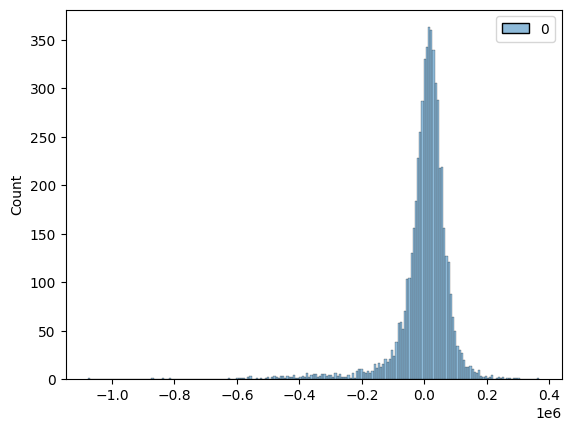

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# 残差
residual = model.predict(X_eval) - y_eval

# ヒストグラム
fig, ax = plt.subplots()
sns.histplot(residual, ax = ax)
plt.show()